In [26]:
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import wandb
import torch.nn as nn


# Set device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device("mps") # for M chip Macs
else:
    DEVICE = torch.device("cpu")

DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

SEED = 42
torch.manual_seed(SEED)
print(f"Using seed {SEED}")

data_path = 'noise_data.pt'

if os.path.exists(data_path):
    print(f"Loading pre-saved tensors from {data_path}...")
    data_dict = torch.load(data_path)
    sent = data_dict['sent'].to(DEVICE)
    received = data_dict['received'].to(DEVICE)
else:
    # file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_ici_clipped_measurements_3.66V.h5"
    # file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_ici_clipped_measurements_2.756V.h5"
    # file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/dynamic_single_X_ici_clipped_measurements_2.757V.h5"
    # file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_3.5V.h5"
    file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_3.5V_v2.h5"

    data_h5 = h5py.File(file_path, 'r')
    all_keys = list(data_h5.keys())

    # Get frequency
    first_frame = list(data_h5.keys())[0]
    FREQUENCIES = torch.tensor(data_h5[first_frame]['freqs'][:]).real
    NUM_POINTS_SYMBOL = int(data_h5[first_frame]['num_points_symbol'][()])


    all_sent = []
    all_rec = []
    received_time = []
    for i, key in enumerate(all_keys):
        sent = torch.tensor(np.array(data_h5[key]["sent"])).squeeze(0)
        received = torch.tensor(np.array(data_h5[key]["received"])).squeeze(0)
        all_sent.append(sent)
        all_rec.append(received)

    sent = torch.vstack(all_sent)
    received = torch.vstack(all_rec)

    # Randominize Data positions
    perm = torch.randperm(len(all_keys))
    sent = sent[perm]
    received = received[perm]
    print("Saving tensors to noise_data.pt...")
    torch.save({
        'sent': sent,
        'received': received
    }, 'noise_data.pt')


delta_f = FREQUENCIES[1] - FREQUENCIES[0]
KS = (FREQUENCIES / delta_f).to(torch.int)
K_MIN = int(KS[0].item())
K_MAX = int(KS[-1].item())
NUM_ZEROS = K_MIN - 1
CP_RATIO = 0.25

Using device: cpu
Using seed 42
Saving tensors to noise_data.pt...


In [27]:
received.shape

torch.Size([680, 762])

In [28]:
# Rectify common phase error and linear phase slope

def rectify_Y(X_i, Y_i, kmin, device):
    X_i = X_i.cpu().numpy()
    Y_i = Y_i.cpu().numpy()
    # Find best approximation for CPE
    theta_s = np.angle(np.mean(X_i * Y_i.conj()))
    Y_1 = np.exp(-1j * theta_s) * Y_i
    angles = np.angle(Y_1 / X_i)
    angles = np.unwrap(angles)
    ks = np.arange(kmin, len(X_i) + kmin)
    slope, intercept = np.polyfit(ks, angles, deg=1)
    Y_2 = np.exp(-1j * (slope * ks + intercept)) * Y_1
    return torch.tensor(Y_2, device=device, dtype=torch.complex64)

def rectify_batch(X: torch.Tensor, Y: torch.Tensor, kmin: int) -> torch.Tensor:
    # X, Y: [B, Nf] complex
    rows = [rectify_Y(X[i], Y[i], kmin, device=Y.device) for i in range(Y.shape[0])]
    return torch.stack(rows, dim=0)

In [29]:
# received = rectify_batch(sent, received, 30)

In [30]:
received.shape

torch.Size([680, 762])

In [31]:
# Just grab in band carriers
# received = received[:, KS]

In [32]:
print(sent.shape, received.shape)

torch.Size([680, 370]) torch.Size([680, 762])


Mean EVM 1.655743835726753e-05
torch.Size([762])


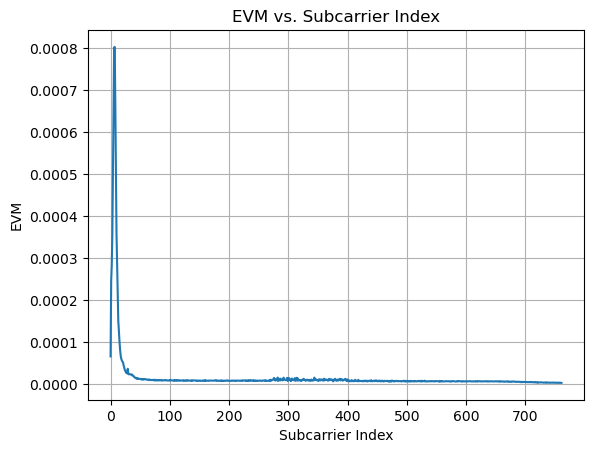

In [33]:
# Calculate mean for each frequency

mean = torch.mean(received, dim=0)
error = received - mean
evm_vs_freq = torch.mean(error.abs().square(), dim=0)

print("Mean EVM", torch.mean(evm_vs_freq).item())
print(evm_vs_freq.shape)
plt.plot(evm_vs_freq.cpu().numpy())
plt.title('EVM vs. Subcarrier Index')
plt.xlabel('Subcarrier Index')
plt.ylabel('EVM')
plt.grid(True)
plt.show()

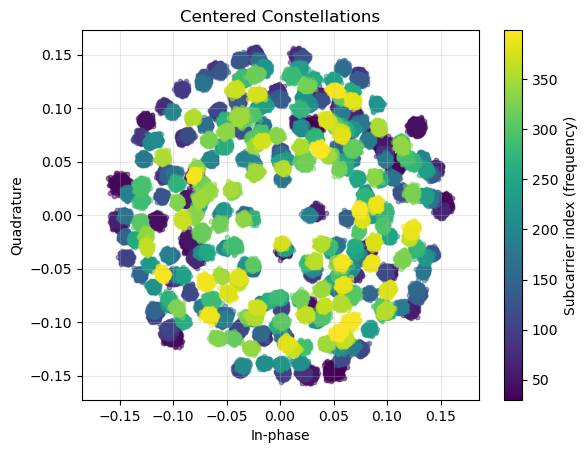

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

def center_and_plot(received, indices, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # normalize indices for colormap
    norm = mcolors.Normalize(vmin=min(indices), vmax=max(indices))
    cmap = cm.viridis

    for idx in indices:
        r = received[:, idx]
        ax.scatter(r.real, r.imag,
                   s=10, alpha=0.5,
                   color=cmap(norm(idx)),
                   label=f"{idx}")

    ax.set_xlabel("In-phase")
    ax.set_ylabel("Quadrature")
    ax.set_title("Centered Constellations")
    ax.grid(True, alpha=0.3)
    ax.axis("equal")

    # add a colorbar keyed to subcarrier index
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Subcarrier index (frequency)")

    return ax

# Example usage
center_and_plot(received, [x for x in range(30, 400, 1)])
plt.show()

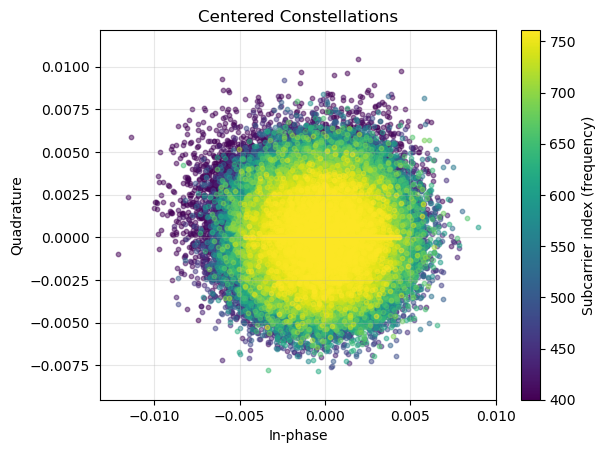

In [35]:
center_and_plot(received, [x for x in range(400, 762, 1)])
plt.show()


Total Mean SNR tensor(355.9665)


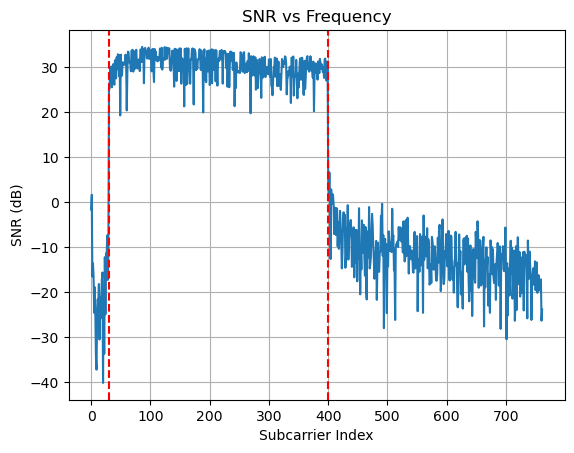

torch.Size([762]) torch.Size([762])
torch.Size([762]) torch.Size([762])
In Band SNR 1276.248779296875
Out of Band SNR 0.1526234894990921


In [39]:
# Calculate the SNR

KS = torch.arange(3e5, 4e6, 1e4) / 1e4
KS = KS.to(int)
mean_symbol = received.mean(dim=0, keepdim=False)
signal_power = (mean_symbol.abs() ** 2).mean()
noise_power = (received - mean_symbol).abs().square().mean()
snr = signal_power / noise_power
print("Total Mean SNR", snr)

# Get SNR vs. Frequency
signal_power_freq = (mean_symbol.abs() ** 2)
noise_power_freq = ((received - mean_symbol)).abs().square().mean(dim=0)
snr_freq = signal_power_freq / noise_power_freq
snr_db = 10 * torch.log10(snr_freq)


plt.plot(snr_db.cpu().numpy())
plt.xlabel("Subcarrier Index")
plt.ylabel("SNR (dB)")
plt.title("SNR vs Frequency")
plt.grid(True)
plt.axvline(KS[0].item(), color='r', linestyle='--')
plt.axvline(KS[-1].item(), color='r', linestyle='--')
plt.show()

print(signal_power_freq.shape, noise_power_freq.shape)

print(signal_power_freq.shape, noise_power_freq.shape)

# Create boolean masks for in-band and out-of-band carriers

# in_band_mask = torch.zeros_like(freq_indices, dtype=torch.bool)
# in_band_mask[KS] = True
# out_band_mask = ~in_band_mask

freq_indices = torch.arange(len(signal_power_freq))
in_band_mask = torch.zeros_like(freq_indices, dtype=torch.bool)
in_band_mask[KS] = True # Set in-band indices to True

# Now use the mask for filtering
in_band_snr = torch.mean(signal_power_freq[in_band_mask] / noise_power_freq[in_band_mask])
out_of_band_snr = torch.mean(signal_power_freq[~in_band_mask] / noise_power_freq[~in_band_mask])

print("In Band SNR", in_band_snr.item())
print("Out of Band SNR", out_of_band_snr.item())